<a href="https://colab.research.google.com/github/naenumtou/statisticalModel/blob/main/pls_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

np.set_printoptions(precision = 4)
%config InlineBackend.figure_format = 'retina'

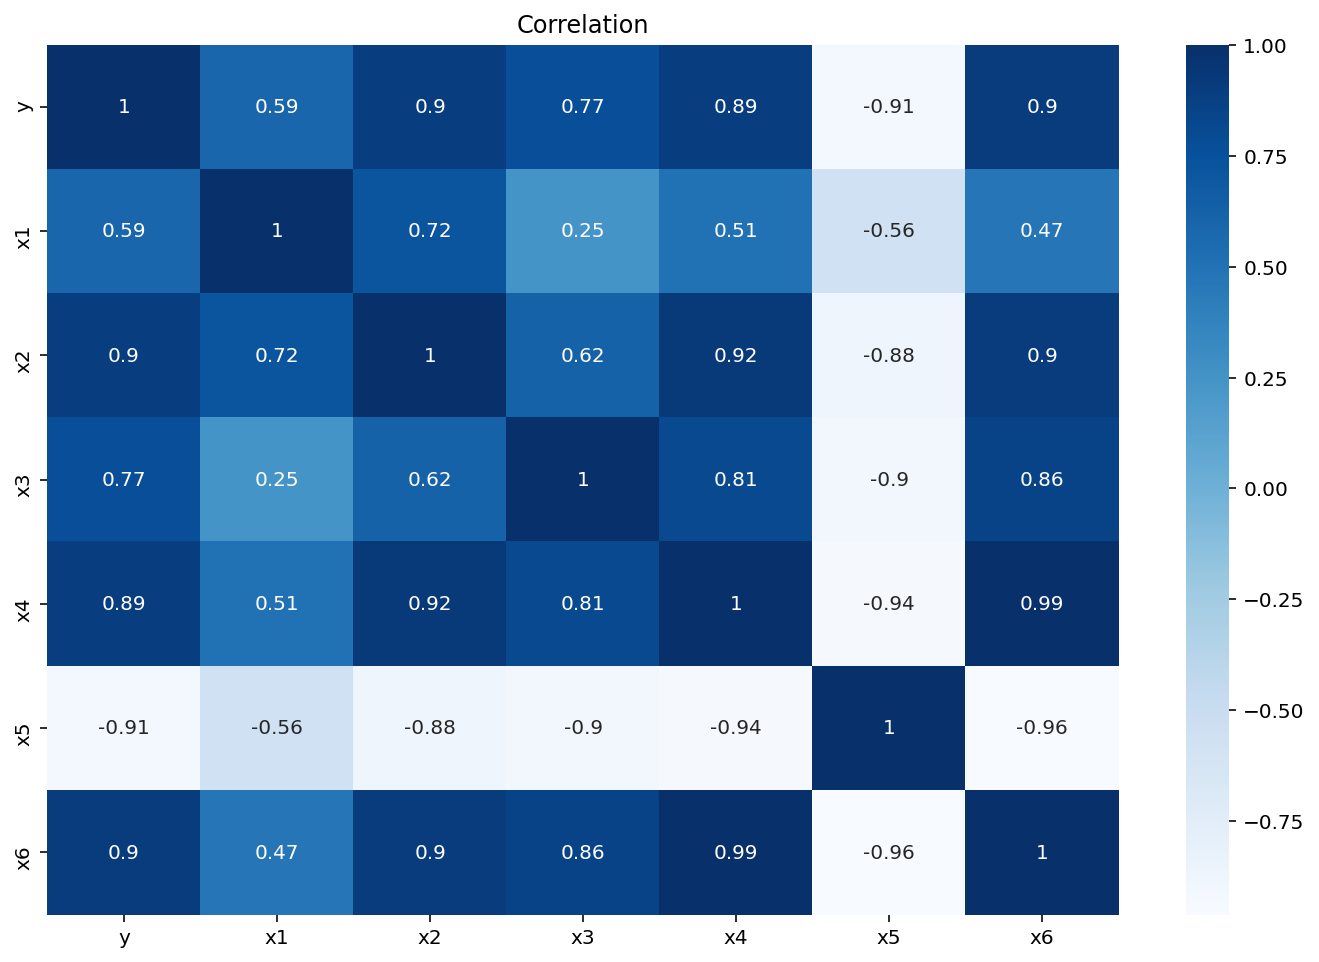

In [ ]:
#Import data
df = pd.read_csv('https://raw.githubusercontent.com/naenumtou/statisticalModel/main/datasets/pcr.csv')

#Correlation
corr = df.corr()
plt.figure(figsize = (12,8))
sns.heatmap(corr, annot = True, cmap = plt.cm.Blues)
plt.title('Correlation')
plt.show()

In [ ]:
#Target and Features split
x = df.drop(['y'], axis = 1)
y = df['y']

#Standardize features
scaler = StandardScaler()
x_scale = scaler.fit_transform(x)
x_scale = pd.DataFrame(x_scale, columns = x.columns)

In [ ]:
#PCA
pca = PCA(n_components = 1) #Decompose to 1 component
pca.fit(x_scale) #Fitting PCA
prin1 = pca.transform(x_scale) #Transform to PCA

#PCR
pcr = LinearRegression()
pcr.fit(prin1, y)

#Model performance
print(f'R-Square: {pcr.score(prin1, y) * 100:.2f}%')
print(f'MSE: {(mean_squared_error(pcr.predict(prin1), y)) * 100:.2f}%')

R-Square: 86.33%
MSE: 12.61%


In [ ]:
#PLS Regression
pls = PLSRegression(n_components = 1)
pls.fit(x_scale, y)

#Model performance
print(f'R-Square: {pls.score(x_scale, y) * 100:.2f}%')
print(f'MSE: {(mean_squared_error(pls.predict(x_scale), y)) * 100:.2f}%')

R-Square: 86.38%
MSE: 12.56%


In [ ]:
#Model results
def compare_model(features, target, components):
  
  #PCR
  pca_model = PCA(n_components = components)
  pca_model.fit(features)
  x_pca = pca_model.transform(features)
  pcr_model = LinearRegression()
  pcr_model.fit(x_pca, target)

  #PLS
  pls_model = PLSRegression(n_components = components)
  pls_model.fit(features, target)

  #Model performance
  pcr_r2 = pcr_model.score(x_pca, target)
  pcr_mse = mean_squared_error(pcr_model.predict(x_pca), target)
  pls_r2 = pls_model.score(features, target)
  pls_mse = mean_squared_error(pls_model.predict(features), target)

  plt.figure(figsize = (10, 6))
  with plt.style.context('seaborn'):
    plt.title('Back-Testing')
    plt.xlabel('Date time')
    plt.plot(y, c = 'royalblue', linewidth = 2.5, label = 'Actual')
    plt.plot(pls_model.predict(features), c = 'firebrick', linestyle = '--', label = f'PLS: n = {components}')
    plt.plot(pcr_model.predict(x_pca), c = 'forestgreen', linestyle = '--', label = f'PCR: n = {components}')
    plt.legend(frameon = True, facecolor = 'white')
  return print(f'PCR R-Square: {(pcr_r2) * 100:.2f}%, MSE: {(pcr_mse) * 100:.2f}%'), print(f'PLS R-Square: {(pls_r2) * 100:.2f}%, MSE: {(pls_mse) * 100:.2f}%'), plt.show()

PCR R-Square: 86.33%, MSE: 12.61%
PLS R-Square: 86.38%, MSE: 12.56%


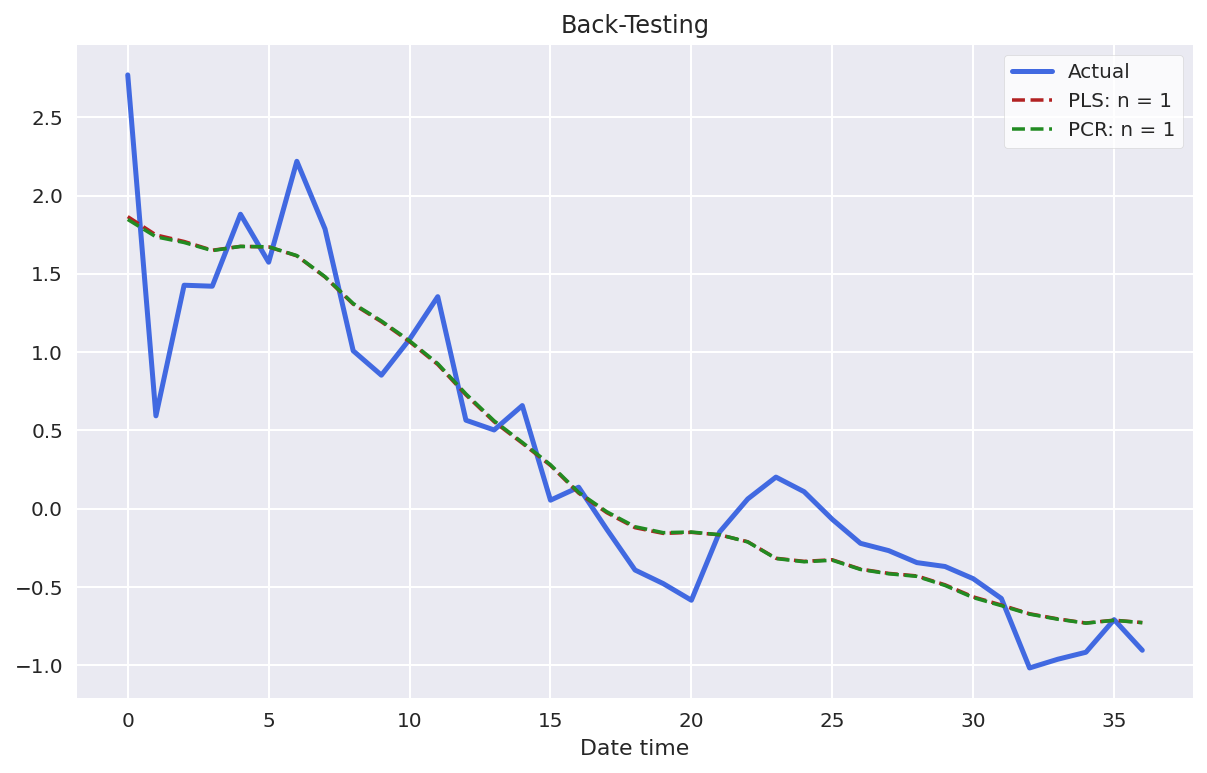

PCR R-Square: 86.42%, MSE: 12.53%
PLS R-Square: 86.62%, MSE: 12.34%


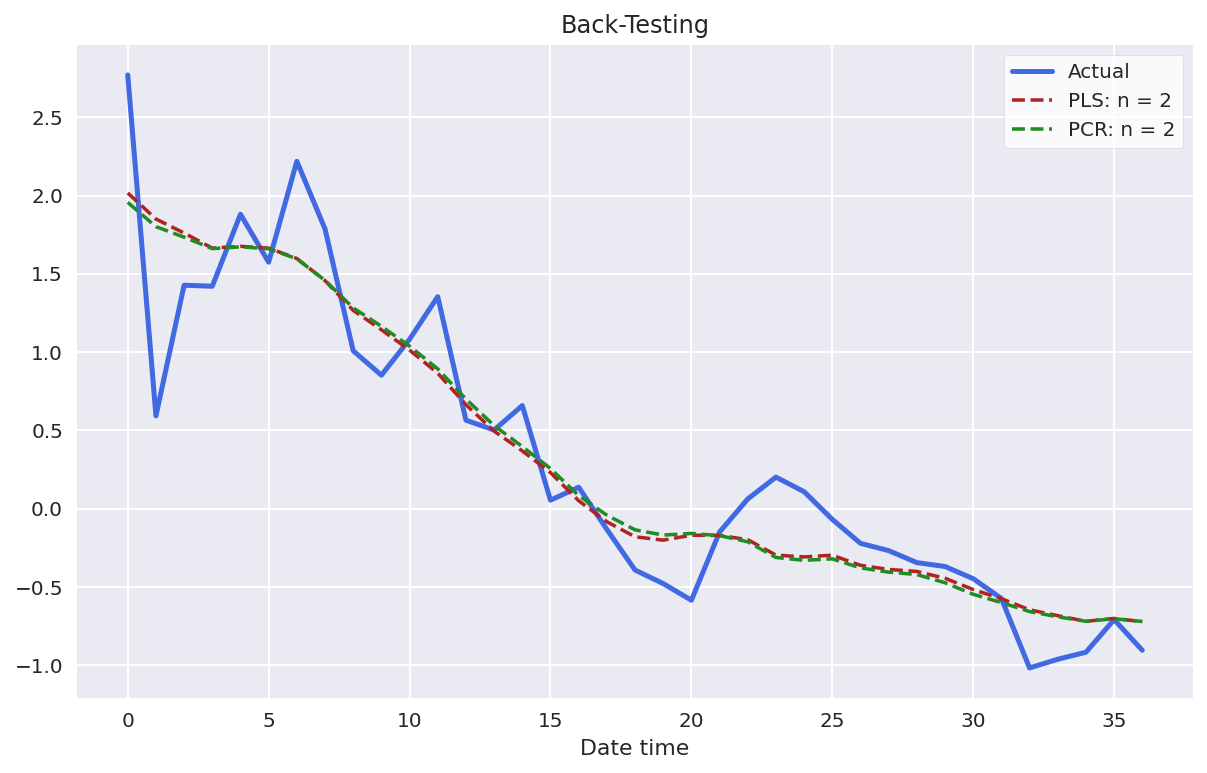

PCR R-Square: 86.45%, MSE: 12.50%
PLS R-Square: 87.77%, MSE: 11.28%


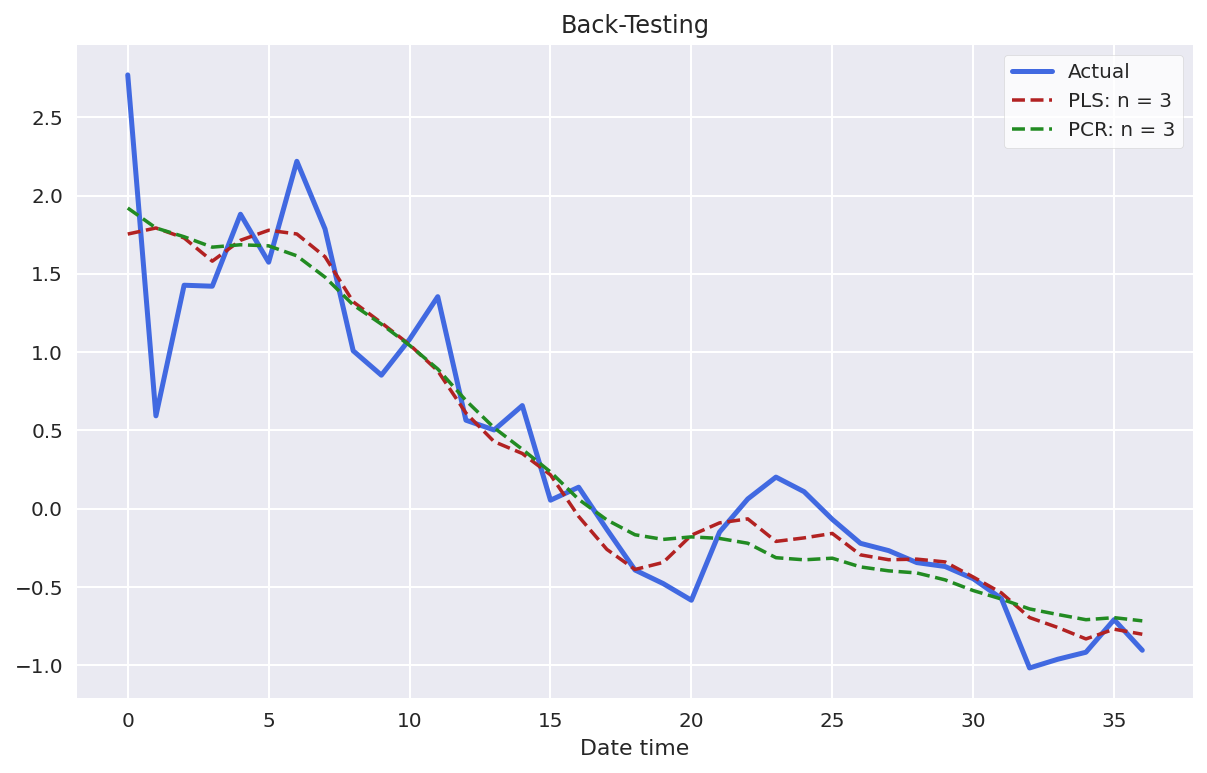

PCR R-Square: 87.71%, MSE: 11.34%
PLS R-Square: 88.42%, MSE: 10.69%


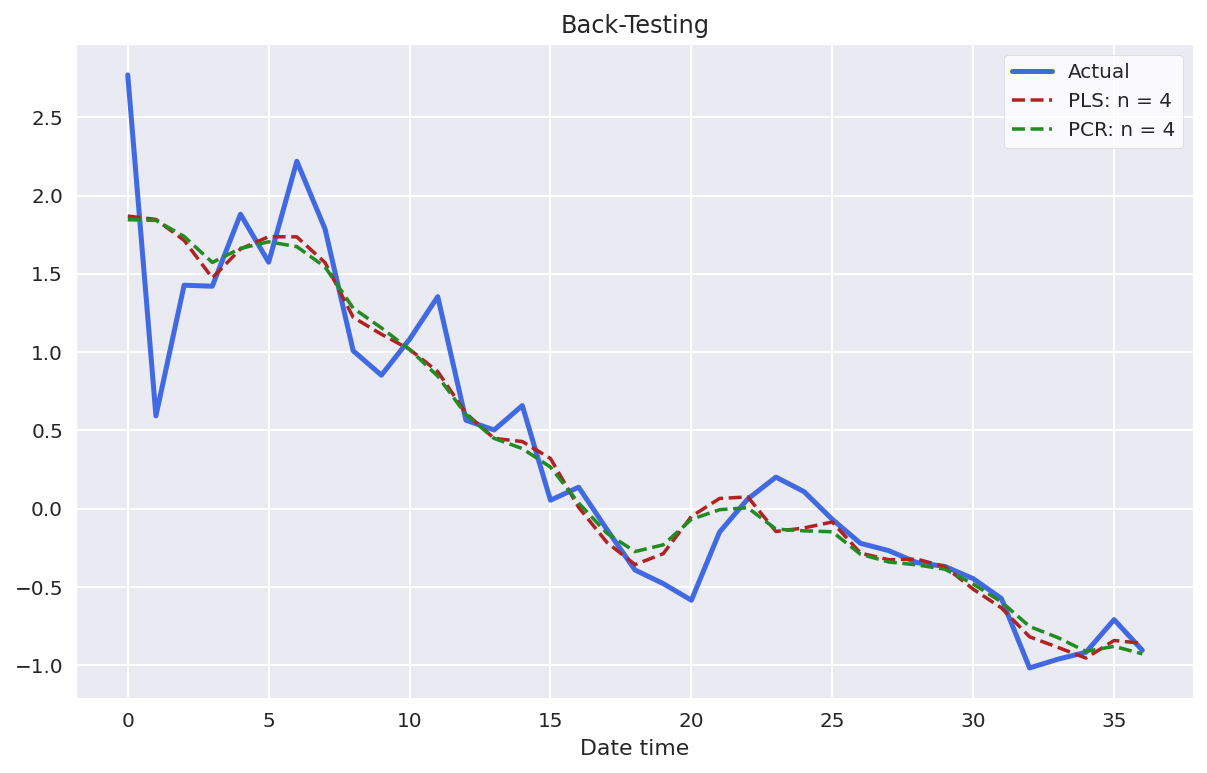

PCR R-Square: 88.81%, MSE: 10.32%
PLS R-Square: 88.96%, MSE: 10.18%


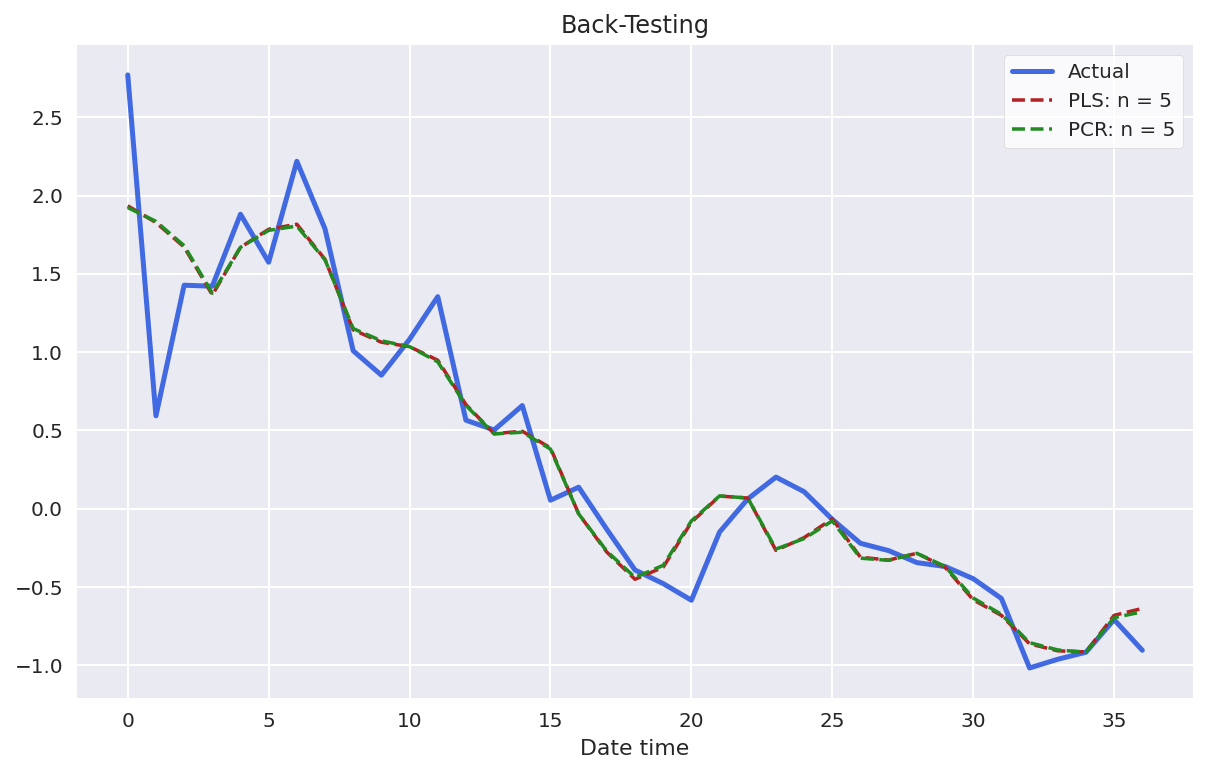

PCR R-Square: 92.27%, MSE: 7.13%
PLS R-Square: 92.27%, MSE: 7.13%


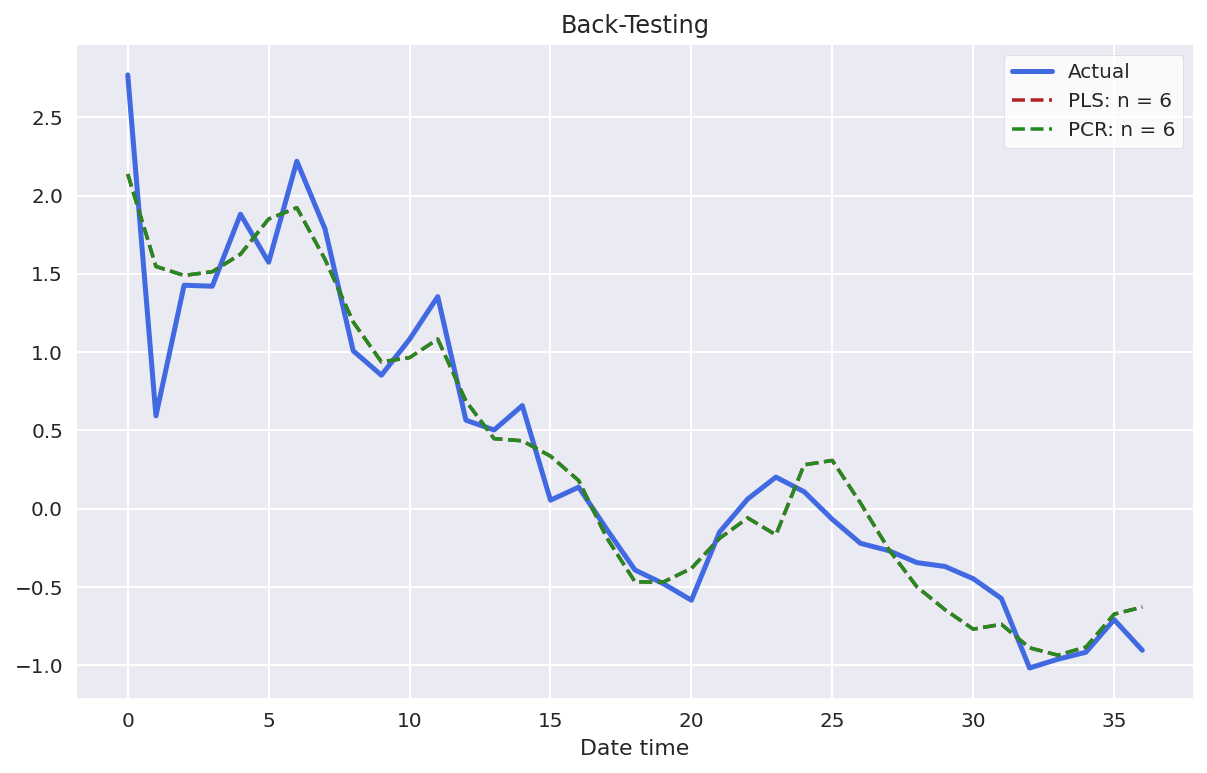

In [ ]:
#Run model with n components
for n in range(1, x_scale.shape[1] + 1):
  compare_model(x_scale, y, n)

In [ ]:
#Optimise PLS
scores = None

for n in range(1, x_scale.shape[1] + 1):
  pls = PLSRegression(n_components = n)
  cv_y = cross_val_predict(pls, x_scale, y, cv = 10)

  #Score
  r_sqaure = r2_score(y, cv_y)
  mse = mean_squared_error(y, cv_y)
  score = np.array((r_sqaure, mse))

  if scores is None:
    scores = score.copy()
  else:
    scores = np.vstack((scores, score))

#Find optimised component
print(f'Optimised component (Highest R-Square): {np.argmax(scores[:, 0]) + 1}')
print(f'Optimised component (Lowest MSE): {np.argmin(scores[:, 1]) + 1}')

Optimised component (Highest R-Square): 4
Optimised component (Lowest MSE): 4


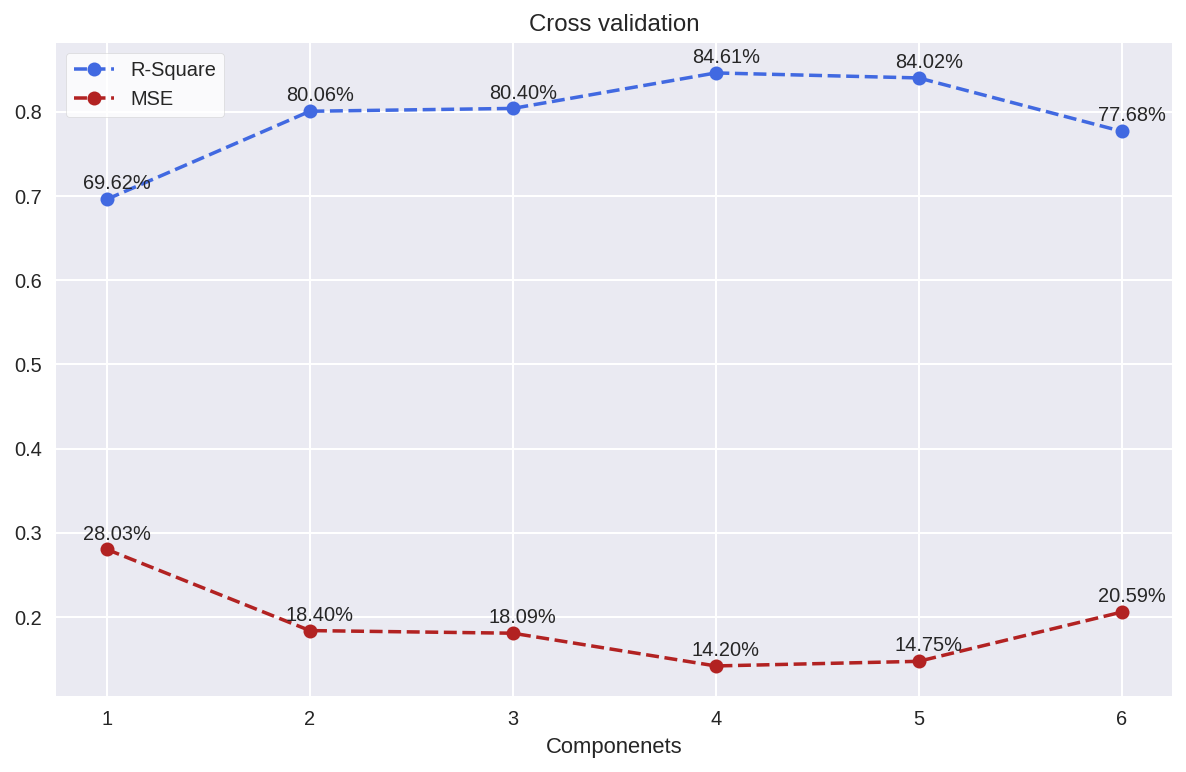

In [ ]:
#Plot cross validation
plt.figure(figsize = (10, 6))
with plt.style.context('seaborn'):
  plt.title('Cross validation')
  plt.xlabel('Componenets')
  plt.plot(range(1, scores.shape[0] + 1), scores[:, 0], c = 'royalblue', marker = 'o', linestyle = '--', label = 'R-Square')
  plt.plot(range(1, scores.shape[0] + 1), scores[:, 1], c = 'firebrick', marker = 'o', linestyle = '--', label = 'MSE')
  for x, r2, mse in zip(range(1, scores.shape[0] + 1), scores[:, 0], scores[:, 1]):
    r2_label = f'{r2 * 100:.2f}%'
    plt.annotate(r2_label, (x, r2), textcoords = 'offset points', xytext = (5, 5), ha = 'center')
    mse_label = f'{mse * 100:.2f}%'
    plt.annotate(mse_label, (x, mse), textcoords = 'offset points', xytext = (5, 5), ha = 'center')
  plt.legend(frameon = True, facecolor = 'white')
  plt.show()